# Visualization of singletable comparisons

The following example runs through plotting of learning curves and critical difference diagrams of the comparing baselines in the CARTE paper. The results should be obtained and compiled following the instructions in the README before running this example.

In [1]:
# Set the current working directory and import packages
import os
from pathlib import Path
os.chdir(Path().cwd().parent)

import copy
import scikit_posthocs as sp
import seaborn as sns
from matplotlib import pyplot as plt
from src.visualization_utils import prepare_result, generate_df_cdd, critical_difference_diagram
from configs.carte_configs import (
    carte_singletable_baselines,
    carte_singletable_color_palette,
    carte_singletable_markers,
)
from configs.carte_configs import carte_singletable_baselines

## 1. Learning Curves
We first set the basic settings for plotting the results. We can choose the task (regression or classification) and import necessary default plotting settings. The plotting settings may be changed and configs/carte_configs.py file.

In [2]:
# Set task, models
task = "regression"  # regression or classification
models = carte_singletable_baselines["reduced"]

# Load results
df_normalized, hue_order = prepare_result(
    task=task,
    models=models,
    rank_at=2048,
)
if task == "classification":
    hue_order.append("TarEnc-TabPFN")

# Plot settings
markers = copy.deepcopy(carte_singletable_markers)
if task == "classification":
    markers.pop("TabVec-Ridge")
else:
    markers.pop("TabVec-Logistic")
    markers.pop("TarEnc-TabPFN")

x_axis = "num_train"
y_axis = "normalized_score"

# paper style
sns.set_theme(style="whitegrid", font_scale=1)

/tmp/ipykernel_19978/788385046.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(yticklabels=[0, 0.2, 0.4, 0.6, 0.8, 1])


Text(0, 0.5, 'Normalized score')

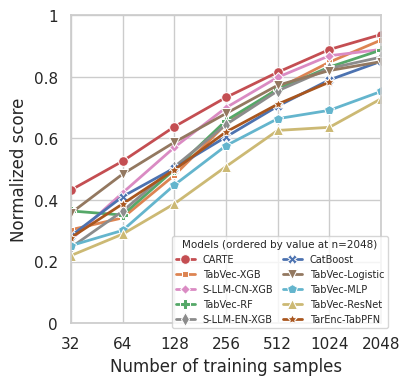

In [3]:
# Plot
fig, axes = plt.subplots(1, 1, figsize=[4, 4])
ax = axes
plt.ylim(0, 1)
plt.xlim(0, 6)

sns.lineplot(
    x=x_axis,
    y=y_axis,
    hue="model",
    hue_order=hue_order,
    style="model",
    data=df_normalized,
    dashes=False,
    markersize=7,
    markers=carte_singletable_markers,
    linewidth=2,
    legend=True,
    err_style="bars",
    errorbar=None,
    palette=carte_singletable_color_palette,  # Use the custom palette
    ax=ax,
)
legend = plt.legend(
    fontsize=7,
    ncol=2,
    columnspacing=0.95,
    loc=(0.325, -0.015),
    numpoints=1,
    title="Models (ordered by value at n=2048)",
)
legend.get_title().set_fontsize("7.5")
plt.setp(legend.get_title(), multialignment="center")

ax.set(yticklabels=[0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlabel("Number of training samples")
ax.set_ylabel("Normalized score")

## 2. Critical Difference Diagram
The following codes will produce the critical difference diagram. Note that for calculation of the test-statistics are based on all train-sizes.

In [4]:
# Set task models
task = "regression"  # regression or classification
models = carte_singletable_baselines["reduced"]

# Load results
df_normalized, _ = prepare_result(
    task=task,
    models=models,
    rank_at=2048,
)

# Generate dataframe for critical difference diagram
df_cdd = generate_df_cdd(df_normalized, train_size="all")

# Ranks and test results
avg_rank = (
    df_cdd.groupby(["case"], group_keys=True)
    .normalized_score.rank(pct=False, ascending=False)
    .groupby(df_cdd.model)
    .mean()
)
avg_rank = -1 * avg_rank
test_results = sp.posthoc_conover_friedman(
    df_cdd,
    melted=True,
    block_col="case",
    group_col="model",
    y_col="normalized_score",
)
test_results = test_results.replace(0, 1e-100) # Required for visualization

# List of models and line style settings
model_list = df_cdd["model"].unique().tolist()
line_style = {model: "-" for model in model_list}

sns.set_theme(style="white", font_scale=1)

/storage/store2/work/mkim/.local/miniconda3/envs/carte_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/tmp/ipykernel_19978/1776753396.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None, 7, 6, 5, 4, 3, 2], fontsize=14)


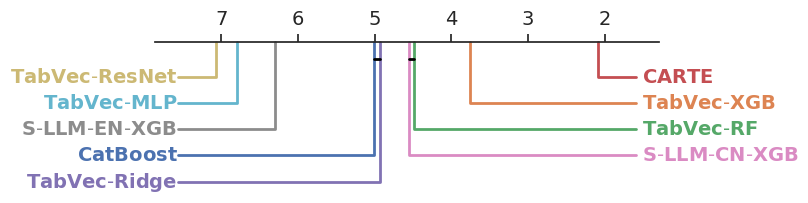

In [5]:
# Plot
fig, axes = plt.subplots(1, 1, figsize=[6.5, 2])
ax = axes

cdd = critical_difference_diagram(
    ranks=avg_rank,
    sig_matrix=test_results,
    label_fmt_left="{label} ",
    label_fmt_right=" {label}",
    label_props={
        "fontsize": 14,
    },
    crossbar_props={"color": "black", "linewidth": 2},
    marker_props={"marker": ""},
    elbow_props={"linewidth": 2},
    text_h_margin=0.5,
    color_palette=carte_singletable_color_palette,
    line_style=line_style,
    ax=ax,
)
if task == "regression":
    ax.set_xticklabels([None, 7, 6, 5, 4, 3, 2], fontsize=14)
else:
    ax.set_xticklabels([None, 8, 7, 6, 5, 4, 3, 2], fontsize=14)

For those interested in the critical difference diagram for full baselines (without the bagging for non-nn methods) the following codes will generate the plot

In [6]:
# Set task models
task = "regression"  # regression or classification
models = carte_singletable_baselines["full"]

# Load results
df_normalized, _ = prepare_result(
    task=task,
    models=models,
    rank_at=2048,
)

# Generate dataframe for critical difference diagram
df_cdd = generate_df_cdd(df_normalized, train_size="all")

# Ranks and test results
avg_rank = (
    df_cdd.groupby(["case"], group_keys=True)
    .normalized_score.rank(pct=False, ascending=False)
    .groupby(df_cdd.model)
    .mean()
)
avg_rank = -1 * avg_rank
test_results = sp.posthoc_conover_friedman(
    df_cdd,
    melted=True,
    block_col="case",
    group_col="model",
    y_col="normalized_score",
)
test_results = test_results.replace(0, 1e-100) # Required for visualization

# List of models and line style settings
model_list = df_cdd["model"].unique().tolist()
line_style = {model: "-" for model in model_list}

color_palette = {
    model: (
        carte_singletable_color_palette[model] if model in carte_singletable_color_palette.keys() else "black"
    )
    for model in model_list
}
for key in color_palette.keys():
    if ("-Bagging" in key) and (key.split("-Bagging")[0] in carte_singletable_color_palette):
        color_palette[key] = carte_singletable_color_palette[key.split("-Bagging")[0]]

sns.set_theme(style="white", font_scale=1)

/storage/store2/work/mkim/.local/miniconda3/envs/carte_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/tmp/ipykernel_19978/767941354.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None, 18, 16, 14, 12, 10, 8, 6, 4, 2], fontsize=16)


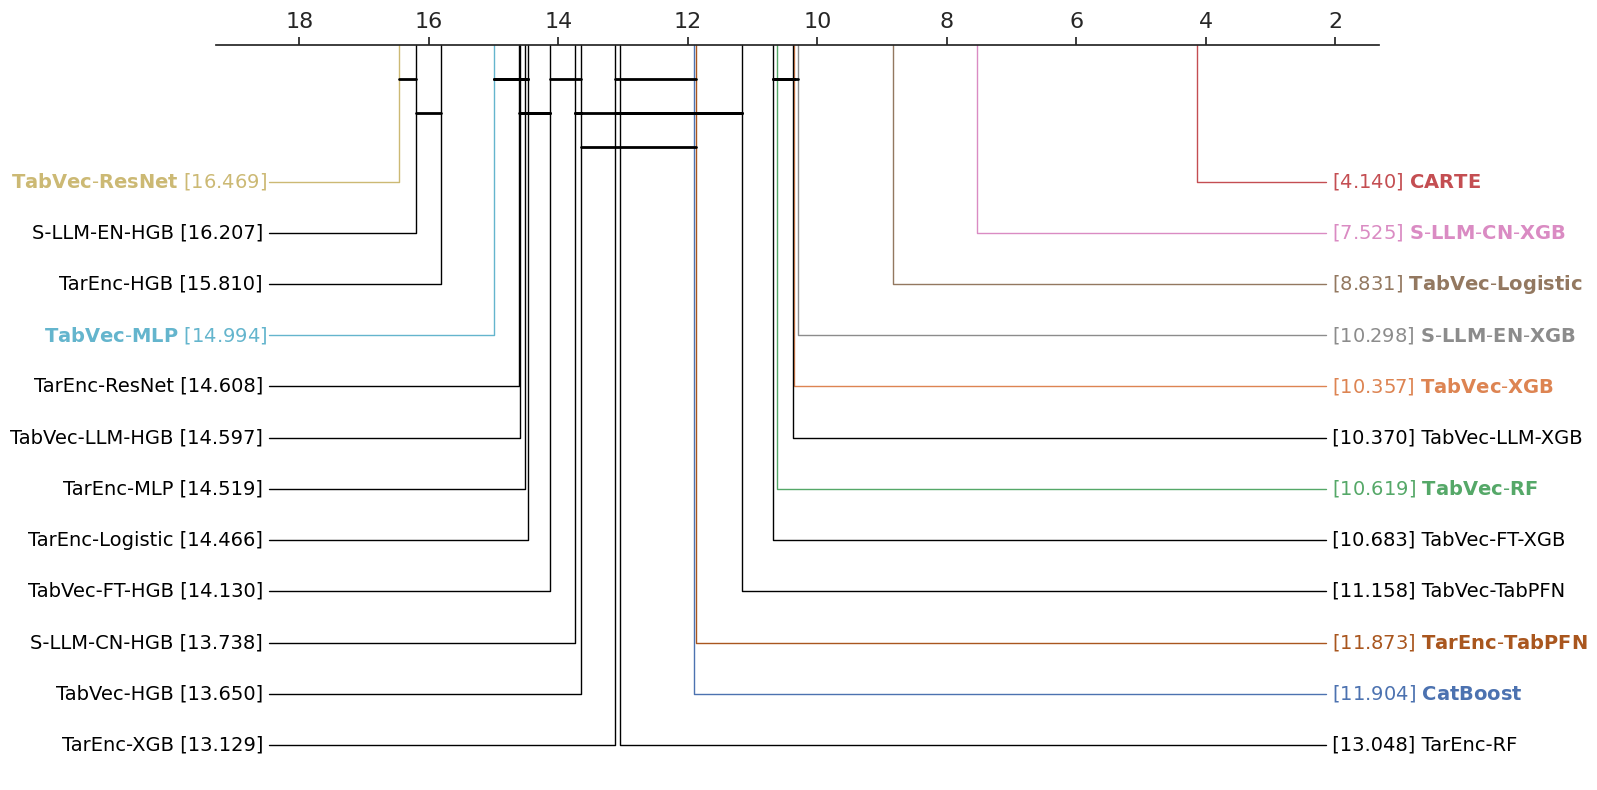

In [7]:
# Plot
fig, axes = plt.subplots(1, 1, figsize=[15, 10])
ax = axes

cdd = critical_difference_diagram(
    ranks=avg_rank,
    sig_matrix=test_results,
    label_fmt_left="{label} [{rank:.3f}] ",
    label_fmt_right=" [{rank:.3f}] {label}",
    label_props={"fontsize": 14},
    crossbar_props={"color": "black", "linewidth": 2},
    elbow_props={"linewidth": 1},
    marker_props={"marker": ""},
    text_h_margin=2,
    color_palette=color_palette,
    line_style=line_style,
    ax=ax,
)

if task == "regression":
    ax.set_xticklabels([None, 17.5, 15, 12.5, 10, 7.5, 5, 2.5], fontsize=16)
else:
    ax.set_xticklabels([None, 18, 16, 14, 12, 10, 8, 6, 4, 2], fontsize=16)